# Brief introduction to Dask
[Dask](https://docs.dask.org/en/stable/) is a library that makes it relatively easy to perform parallel and distributed computations in python.

The key concept for us is that allows for computations that **require more memory than available** on your machine.

In [1]:
# First some imports.
import dask
import dask.array as da
import numpy as np
import xarray as xr

from dask.distributed import Client
from matplotlib import pyplot as plt

I like to start a client, since this allows me to control how many workers and memory it can use.
And it starts the dashboard, which can give use some nice insights on our computations.

In [2]:
from dask.distributed import Client

client = Client()

In [3]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/fc%3Auid%3A8be9434f-5560-4397-97c0-882449c50503/proxy/8787/status,
Dashboard: /user/fc%3Auid%3A8be9434f-5560-4397-97c0-882449c50503/proxy/8787/status,Workers: 4
Total threads: 16,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42435,Workers: 4
Dashboard: /user/fc%3Auid%3A8be9434f-5560-4397-97c0-882449c50503/proxy/8787/status,Total threads: 16
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:36459,Total threads: 4
Dashboard: /user/fc%3Auid%3A8be9434f-5560-4397-97c0-882449c50503/proxy/36155/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:46681,


<div class="alert alert-block alert-info">
    <b>Info</b>
    If you are running multiple notebooks at the same time, utilising dask, it is a good idea to start the client through the dask extension available on the left side menu.
    This enables you to run all computations on the same client.
</div>

Let's say we have some large array we want to do some work on.
Here we'll illustrate this with a `(100000, 20000)` array with random numbers 

In [4]:
rng = np.random.default_rng()

In [ ]:
data_np = rng.standard_normal((100000, 25000))

Likely, your kernel is going to crash running this cell.

Let us instead try it with dask:

In [5]:
rng_da = da.random.default_rng()

In [6]:
data_da = rng_da.standard_normal((100000, 25000))

Have a look at the data, this is currently a lazy Dask array.

In [7]:
data_da

dask.array<standard_normal, shape=(100000, 25000), dtype=float64, chunksize=(4096, 4096), chunktype=numpy.ndarray>

Then we can create the histogram computation

In [8]:
hist, bins = da.histogram(data_da, bins=20, range=(-3, 3))

Note that the histogram hasn't been computed yet (it is lazy).
Here we can also double-check that the result will fit in memory.

In [9]:
hist

dask.array<sum-aggregate, shape=(20,), dtype=int64, chunksize=(20,), chunktype=numpy.ndarray>

To actually compute the result, we call the `compute` method on the result.

In [10]:
hist = hist.compute()

Plot it to make sure it follows the normal distribution we would expect.

<BarContainer object of 20 artists>

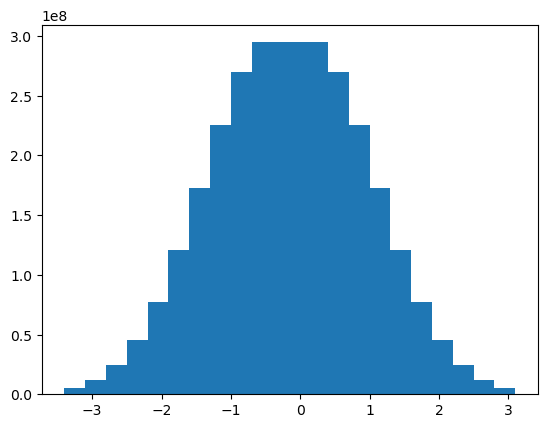

In [11]:
plt.bar(bins[:-1], hist)

# Xarray + Dask
xarray is an interface to array data like Numpy, or often Dask.

Below we load some MERRA data.
Specifying `chunks="auto"` is optional but it makes sure data is read as Dask arrays.

In [12]:
merra_ds = xr.open_mfdataset(
    "/mnt/craas1-ns9989k-ns9600k/escience_course/MERRA2/MERRA2_300.inst3_3d_aer_Nv.200*.SUB.nc",
    chunks="auto"
)

One of the variables of the dataset

In [13]:
merra_ds.SS001

<xarray.DataArray 'SS001' (time: 8768, lev: 3, lat: 121, lon: 576)> Size: 7GB
dask.array<concatenate, shape=(8768, 3, 121, 576), dtype=float32, chunksize=(8, 3, 121, 576), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 70kB 2007-01-01 ... 2009-12-31T21:00:00
  * lon      (lon) float64 5kB -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
  * lat      (lat) float64 968B 30.0 30.5 31.0 31.5 32.0 ... 88.5 89.0 89.5 90.0
  * lev      (lev) float64 24B 56.0 63.0 67.0
Attributes:
    standard_name:   Sea Salt Mixing Ratio (bin 001)
    long_name:       Sea Salt Mixing Ratio (bin 001)
    units:           kg kg-1
    fmissing_value:  1000000000000000.0
    vmax:            1000000000000000.0
    vmin:            -1000000000000000.0

Xarray recognizes that the data is in the form of a dask array.
The following will work as we expect, and be “parallelized” in the background using dask (Look at the Progress in the dashboard).

In [14]:
mean_ds = merra_ds.SS001.mean(dim="time").compute()

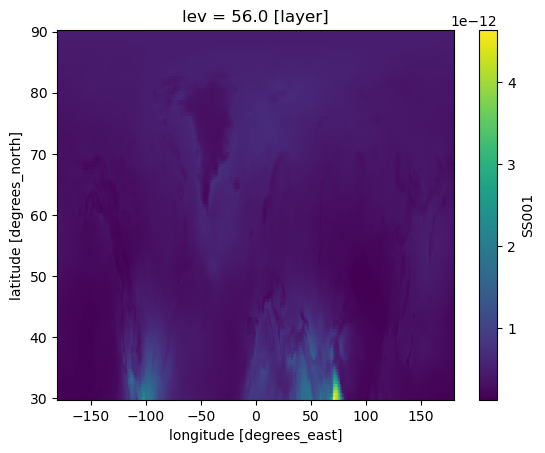

In [15]:
mean_ds.isel(lev=0).plot()

## Working with chunks
But some computations are a bit more tricky.
This won't work.

In [16]:
merra_ds.SS001.quantile(0.85, dim="time")

ValueError: dimension time on 0th function argument to apply_ufunc with dask='parallelized' consists of multiple chunks, but is also a core dimension. To fix, either rechunk into a single array chunk along this dimension, i.e., ``.chunk(dict(time=-1))``, or pass ``allow_rechunk=True`` in ``dask_gufunc_kwargs`` but beware that this may significantly increase memory usage.

If we read the error message, it says something about that the dimension on the 0th function argument to `apply_ufunc` consists of multiple chunks.
This has to do with that there is no parallel implementation of the quantile algorithm — it needs to see all time steps.
To solve this, we can `rechunk` our data.
In this case, we declare that the data should not be chunked along the time dimension, but can be chunked freely along other dimensions.

<div class="alert alert-block alert-info">
    <b>Note that rechunking adds some extra computations.</b>
</div>


In [17]:
qtile = merra_ds.SS001.chunk({"time":-1, "lon": "auto", "lat": "auto", "lev": "auto"}).quantile(0.85, dim="time").compute()

2024-05-20 09:20:43,990 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.60 GiB -- Worker memory limit: 4.00 GiB
2024-05-20 09:20:44,768 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.43 GiB -- Worker memory limit: 4.00 GiB
2024-05-20 09:20:58,762 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- U

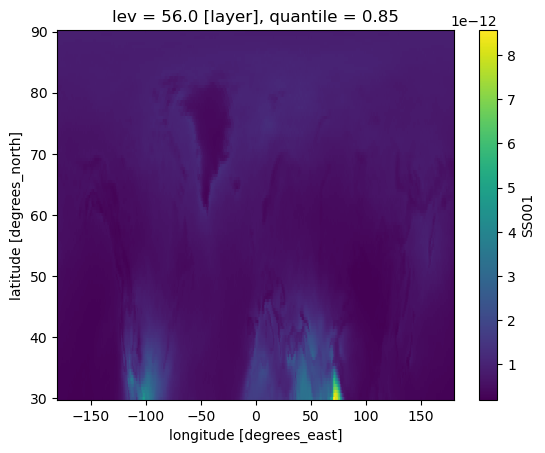

In [18]:
qtile.isel(lev=0).plot()

## Accessing the dask array
Not all operations available in Numpy/Dask are wrapped by xarray.
For instance, to compute the histogram (not plotting) you could do something like this:
```python
np.histogram(merra_ds.SS0001.values)
```
where calling `values` **always** gives us the underlying Numpy array.
If the dataset is backed by Dask arrays, they will be loaded into memory — which is a problem if the data is too big.
Instead you could use the `data` attribute of a dataset, which will return the Dask array:


In [19]:
merra_ds.SS001.data

dask.array<concatenate, shape=(8768, 3, 121, 576), dtype=float32, chunksize=(8, 3, 121, 576), chunktype=numpy.ndarray>

With this we have an array we can pass to Dask array specific functions such as

In [20]:
hist, bins = da.histogram(merra_ds.SS001.data, bins=10, range=(0, merra_ds.SS001.max()))

In [21]:
bins

dask.array<linspace, shape=(11,), dtype=float64, chunksize=(11,), chunktype=numpy.ndarray>

Then we have to compute the histogram

In [22]:
hist.compute()

array([1833234752,      47344,       1173,        202,         80,
               24,          5,          2,          1,          1])

# Numba
[Numba](https://numba.pydata.org/) is a just-in-time compiler for python, which can speed up your slow python-loops, if they work on the supported data types (see documentation).

In [23]:
rng = np.random.default_rng()

In [24]:
test = rng.random((10000, 2))
test2 = rng.random((10000, 2))

The `njit` decorator will try to compile a function the first time it is run.
It will raise an error if numba is not able to compile the function. 

In [25]:
from numba import njit

Here, we have two identical functions that search for matching coordinate pairs in two relatively large arrays.
In reality this could be real coordinates, now we just use random numbers.

In [26]:
def slow_coord_isin(ds_locs, merra_locs):
    mask = np.zeros(ds_locs.shape[0])
    for i, ds_coord in enumerate(ds_locs):
        for merra_coord in merra_locs:
            if ds_coord[0] == merra_coord[0] and ds_coord[1] == merra_coord[1]:
                mask[i] = 1
                break
    return mask

# Here we add the njit decorator.
@njit
def fast_coord_isin(ds_locs, merra_locs):
    mask = np.zeros(ds_locs.shape[0])
    for i, ds_coord in enumerate(ds_locs):
        for merra_coord in merra_locs:
            if ds_coord[0] == merra_coord[0] and ds_coord[1] == merra_coord[1]:
                mask[i] = 1
                break
    return mask

Use the `%%time` cell magic to time the functions.
For more robust timings use the `%%timeit` cell magic.

In [27]:
%%time
slow_coord_isin(test, test)

CPU times: user 10.9 s, sys: 72.2 ms, total: 10.9 s
Wall time: 10.9 s


array([1., 1., 1., ..., 1., 1., 1.])

In [28]:
%%time
fast_coord_isin(test, test)

CPU times: user 639 ms, sys: 60.8 ms, total: 700 ms
Wall time: 690 ms


array([1., 1., 1., ..., 1., 1., 1.])